Data Mining project: credit card default

Pipeline + Ensemble ML (Naive | SVM | knn | logistic regression)

In [1]:
#Importing pertinent libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from scipy import optimize
from scipy.stats import norm
from scipy.stats import mode
from tqdm import tqdm, tqdm_notebook
import math
import random
import statistics 
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
import scipy.stats as stats
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler

In [2]:
#Importing the Dataset
df=  pd.read_excel('default of credit card clients.xlsx')
df.rename(columns=df.iloc[0], inplace = True)
df.drop(df.index[0], inplace = True)

In [3]:
#Checking the Null values in the dataset
df.isnull().sum(axis = 0)

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [4]:
#Renaming the columns for better understanding
df.rename(columns={'default payment next month':'def_pay'}, inplace=True)
df.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

In [5]:
#Replacing the impertinent values in the Education column
df.EDUCATION.replace(5, 
           4, 
           inplace=True)
df.EDUCATION.replace(6, 
           4, 
           inplace=True)
df.EDUCATION.replace(0, 
           4, 
           inplace=True)

In [6]:
#Replacing the impertinent values in the Marriage column
df.MARRIAGE.replace(0, 
           3, 
           inplace=True)

In [7]:
#Generating another column from our dataset(Total amount due= Total payment _ Total Bill)
df['Total_due']=df['PAY_AMT1'] + df['PAY_AMT2']+ df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']-df['BILL_AMT1'] - df['BILL_AMT2'] - df['BILL_AMT3'] - df['BILL_AMT4'] - df['BILL_AMT5'] - df['BILL_AMT6']

# swaping columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

df = swap_columns(df, 'Total_due', 'def_pay')
data=df.astype('int')

### Contradictions in Datatset

There are some contradicting data in the dataset. It could be error when building up the data, or incomplete definition and explanation. Althought there is additional information in discussion, still couldn't explain all.


1) One of the contradicting information is those who Paid in Full in recent month, turn out to be default

In [8]:
df2=df.rename(columns={'def_pay': 'DEFAULT'})
con1 = df2.query('BILL_AMT1 == 0 and DEFAULT == 1').loc[:,('ID','BILL_AMT1','DEFAULT')]
con1.sample(5)

,ID,BILL_AMT1,DEFAULT
25609,25609,0,1
882,882,0,1
8782,8782,0,1
10508,10508,0,1
24785,24785,0,1


2) Some client paid more than they should be, resulting a Negative Bill Amount. But still end up being default

In [9]:
con2 = df.query('BILL_AMT1 < 0').loc[:,('ID','LIMIT_BAL','BILL_AMT1')]
con2.sample(5)

,ID,LIMIT_BAL,BILL_AMT1
23820,23820,400000,-9
16855,16855,270000,-12
22970,22970,240000,-25
29081,29081,120000,-200
7073,7073,200000,-780


3) Some client Bill Amount is much higher than their Credit Limit provided, which seldom happen in real case

In [10]:
con3 = df.query('BILL_AMT1 > LIMIT_BAL').loc[:,('ID','LIMIT_BAL','BILL_AMT1')]
con3.sample(5)

,ID,LIMIT_BAL,BILL_AMT1
13151,13151,320000,321281
13830,13830,30000,30739
17142,17142,130000,187600
12049,12049,50000,51203
585,585,50000,50300


### Anova Testing to determine relevent features
#H0-Attribute does not affect the target variable


#HA- Attribute affects the target variable
#Using the value of alpha as 5%

We performed ANOVA testing (with an alpha value 0f 5%) above that value we consider the Null hypothesis to be true and reject the affect of the column’s impact on the target variable, thus we select only those attributes with PR(>F) <5%.


In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
df=df.astype('int')
model=ols('def_pay ~ LIMIT_BAL + SEX + EDUCATION + MARRIAGE + AGE + PAY_1+ PAY_2+ PAY_3+ PAY_4+ PAY_5+ PAY_6+ BILL_AMT1+ BILL_AMT2+ BILL_AMT3+ BILL_AMT4+ BILL_AMT5+ BILL_AMT6+ PAY_AMT1+ PAY_AMT2+ PAY_AMT3+ PAY_AMT4+ PAY_AMT5 + PAY_AMT6 + Total_due',data=df).fit()
q=sm.stats.anova_lm(model)

print(q)

                df       sum_sq     mean_sq            F         PR(>F)
LIMIT_BAL      1.0   121.803998  121.803998   806.600475  4.147932e-175
SEX            1.0     6.761751    6.761751    44.777113   2.246736e-11
EDUCATION      1.0     0.004767    0.004767     0.031569   8.589775e-01
MARRIAGE       1.0    11.256378   11.256378    74.541063   6.227898e-18
AGE            1.0     1.623953    1.623953    10.754006   1.041724e-03
PAY_1          1.0   444.926928  444.926928  2946.358716   0.000000e+00
PAY_2          1.0    13.745256   13.745256    91.022711   1.524021e-21
PAY_3          1.0     2.803455    2.803455    18.564811   1.647468e-05
PAY_4          1.0     0.288826    0.288826     1.912638   1.666809e-01
PAY_5          1.0     0.134150    0.134150     0.888357   3.459305e-01
PAY_6          1.0     0.061280    0.061280     0.405802   5.241126e-01
BILL_AMT1      1.0    30.413245   30.413245   201.400106   1.452161e-45
BILL_AMT2      1.0     0.082220    0.082220     0.544467   4.605

In [12]:
df_new1=df.drop(["ID", "EDUCATION","PAY_4","PAY_5","PAY_6","BILL_AMT2","BILL_AMT3","BILL_AMT4" ,"BILL_AMT5","BILL_AMT6","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","Total_due"], 1)

In [13]:
columns_df_for_model = df_new1.columns
columns_df_for_model

Index(['LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'def_pay'],
      dtype='object')

In [14]:
print(df_new1)
print(df_new1.shape)
z = np.abs(stats.zscore(df_new1))
#only keep rows in dataframe with all z-scores less than absolute value of 3 
df_for_model = df_new1[(z<3).all(axis=1)]
#find how many rows are left in the dataframe 
print(df_for_model.shape)
print(df_for_model)

       LIMIT_BAL  SEX  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  BILL_AMT1  \
1          20000    2         1   24      2      2     -1       3913   
2         120000    2         2   26     -1      2      0       2682   
3          90000    2         2   34      0      0      0      29239   
4          50000    2         1   37      0      0      0      46990   
5          50000    1         1   57     -1      0     -1       8617   
...          ...  ...       ...  ...    ...    ...    ...        ...   
29996     220000    1         1   39      0      0      0     188948   
29997     150000    1         2   43     -1     -1     -1       1683   
29998      30000    1         2   37      4      3      2       3565   
29999      80000    1         1   41      1     -1      0      -1645   
30000      50000    1         1   46      0      0      0      47929   

       PAY_AMT1  PAY_AMT2  def_pay  
1             0       689        1  
2             0      1000        1  
3          1518      150

In [15]:
# Preparing X and y dataset for training models
df_x = df_for_model.copy()
df_x = df_x.drop(['def_pay'],1)
columns_df_x = df_x.columns

final_y = df_for_model['def_pay']

X_norm = df_x.values
y_norm = final_y.values
y_norm = np.reshape(y_norm,(y_norm.shape[0],1))

# train test split
X_train_norm, X_test, y_train_norm, y_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=234)

# Over sample and Under sample method

ros_over = SMOTE(random_state=42)
rose_under = RandomUnderSampler(random_state=42)

X_train_over, y_train_over = ros_over.fit_resample(X_train_norm, y_train_norm)
X_train_under, y_train_under = rose_under.fit_resample(X_train_norm,y_train_norm)






# Ensemble Machine learning Class

In [16]:
class Ensemble_ML_Models_Class:
    def __init__(self):
        None

    def train (self,X_train, y_train):
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        knn = KNeighborsClassifier(n_neighbors=23)
        knn.fit(X_train, y_train)
        svm = SVC(kernel='rbf')
        svm.fit(X_train , y_train)
        logr = LogisticRegression()
        logr.fit(X_train , y_train)
        self.gnb = gnb
        self.knn = knn
        self.svm = svm
        self.logr = logr
        
    def predict (self, X_test):
        y_pred_gnb = self.gnb.predict(X_test)
        y_pred_knn = self.knn.predict(X_test)
        y_pred_svm = self.svm.predict(X_test)
        y_pred_logr = self.logr.predict(X_test)
        y_pred = np.vstack([y_pred_gnb,y_pred_knn,y_pred_svm,y_pred_logr])
        Notzero = np.count_nonzero(y_pred, axis=0)
        Notzero[Notzero<2] = 0
        Notzero[Notzero>=2] = 1
        y_pred = Notzero
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>=0.5] = 1
        
        return y_pred
        


# Pipeline Class

In [17]:
class Pipeline:
    def __init__(self):
        return None
        
    # plot 2 component pca    
    def pca_2comp(self,X,y):
        
        sc = StandardScaler()
        
        pca = PCA (n_components = 2)
        principalComponents = pca.fit_transform(sc.fit_transform(X))

        plt.scatter(principalComponents[:,0], principalComponents[:,1], c=y ,edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title(self.title)

    def train(self,X,y):
        
        sc = StandardScaler()
        X_norm = sc.fit_transform(X)
        self.sc = sc
        
        pca = PCA(0.9)
        X_norm_pca = pca.fit_transform(X_norm)
        self.pca = pca
        
        model = Ensemble_ML_Models_Class () 
        model.train(X_norm_pca, y)
            
        self.model = model  
    
        
    def predict(self, X):
        
        X_norm = self.sc.transform(X)
        X_norm_pca = self.pca.transform(X_norm)
        
        y_pred = self.model.predict(X_norm_pca)    
        
        
        return y_pred
        
    def compiler(self, X, y, title, test_size):
        
        self.title = title
        self.pca_2comp(X,y)
        self.train(X,y) 


# Pipeline Normal

C:\Users\iliac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\iliac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\iliac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\iliac\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConve

precision score for data normal is: 
0.577560975609756
accuracy score for data normal is: 
0.8006620950579333
Confusion Matrix is: 
[[6180  433]
 [1253  592]]


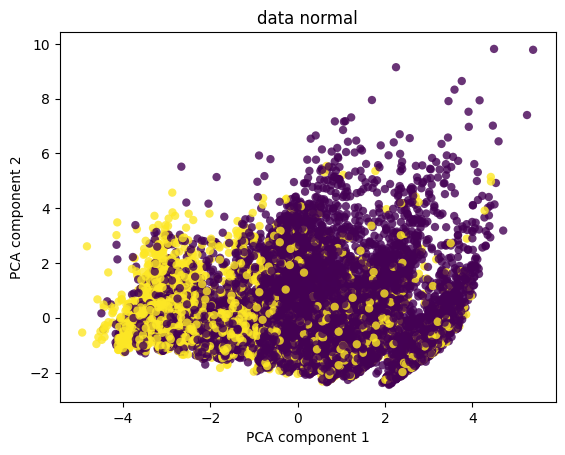

In [18]:
pipeline_norm = Pipeline()

pipeline_norm.compiler(X = X_train_norm, y = y_train_norm, title = 'data normal', test_size = 0.3)

y_pred = pipeline_norm.predict(X_test)

print('precision score for data normal is: ')
Normal_data_prec = precision_score(y_test, y_pred)
print(Normal_data_prec)
print('accuracy score for data normal is: ')
Normal_data_acc = accuracy_score(y_test, y_pred)
print(Normal_data_acc)

CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is: ')
print(CM)


# Pipleline with undersampling

precision score for undersample data is: 
0.3315643164013141
accuracy score for undersample data is: 
0.6242610546228423
Confusion Matrix is: 
[[3968 2645]
 [ 533 1312]]


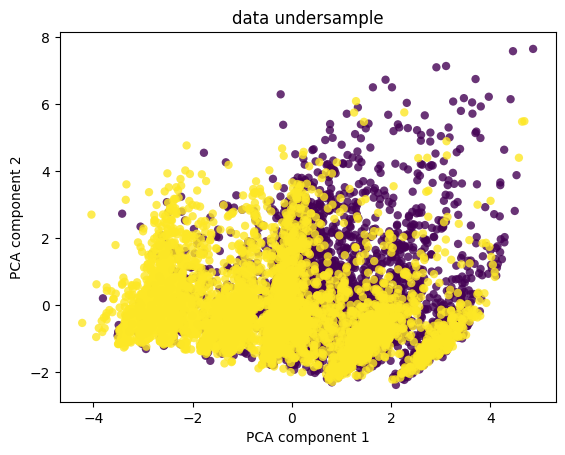

In [20]:
pipeline_under = Pipeline()

pipeline_under.compiler(X = X_train_under, y = y_train_under, title = 'data undersample', test_size = 0.3)

y_pred = pipeline_under.predict(X_test)

print('precision score for undersample data is: ')
Undersample_data_prec = precision_score(y_test, y_pred)
print(Undersample_data_prec)
print('accuracy score for undersample data is: ')
Undersample_data_acc = accuracy_score(y_test, y_pred)
print(Undersample_data_acc)

CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is: ')
print(CM)

# Pipeline with oversampling

precision score for oversample data is: 
0.34171138096582887
accuracy score for oversample data is: 
0.6493260818160321
Confusion Matrix is: 
[[4282 2331]
 [ 635 1210]]


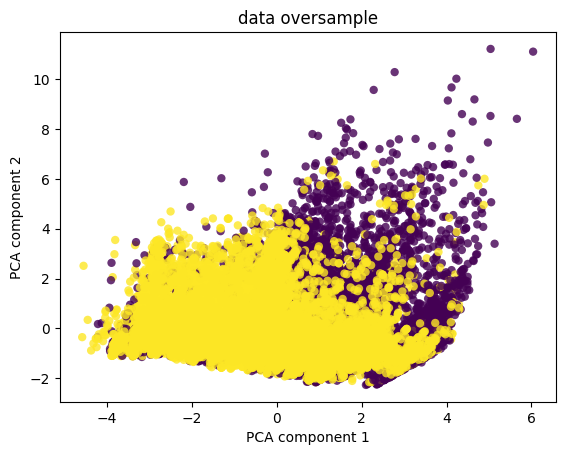

In [22]:
pipeline_over = Pipeline()

pipeline_over.compiler(X = X_train_over, y = y_train_over, title = 'data oversample', test_size = 0.3)

y_pred = pipeline_over.predict(X_test)

print('precision score for oversample data is: ')
Oversample_data_prec = precision_score(y_test, y_pred)
print(Oversample_data_prec)
print('accuracy score for oversample data is: ')
Oversample_data_acc = accuracy_score(y_test, y_pred)
print(Oversample_data_acc)

CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is: ')
print(CM)


<Figure size 2500x2500 with 0 Axes>

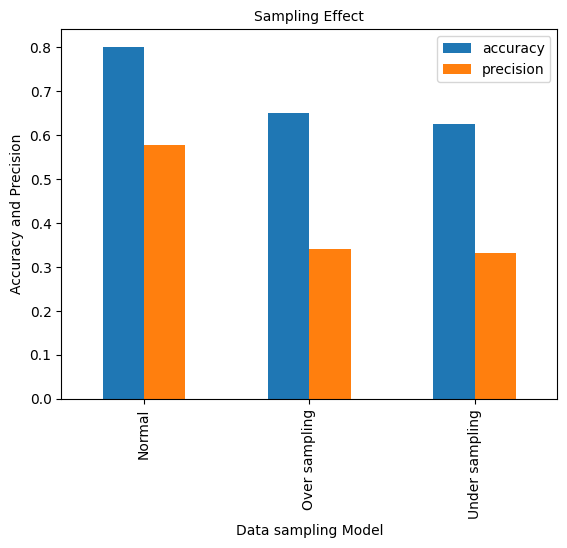

In [23]:
evaluation_comparison = {"Normal": {"accuracy":Normal_data_acc, "precision":Normal_data_prec}, 
                         "Over sampling": {"accuracy":Oversample_data_acc, "precision":Oversample_data_prec},
                         "Under sampling": {"accuracy":Undersample_data_acc, "precision":Undersample_data_prec},
                         }
df_comparison= pd.DataFrame(evaluation_comparison)
df_comparison=df_comparison.T
plt.figure(figsize = (25,25))
df_comparison.plot(kind="bar", fontsize=10)
plt.xlabel("Data sampling Model",fontsize=10)
plt.ylabel("Accuracy and Precision",fontsize=10)
plt.title('Sampling Effect' ,fontsize=10)
plt.legend(["accuracy","precision"], fontsize=10)

plt.show()